# County Residence Interface

County residents upon logging in, are provided with an interface where they are able to select their county of 

residence from a predefined list which we are going to fetch from an API that contains the list of the 47 counties.

The application utilises natural language processing techniques to analyse the input from residents and extract 

relevant information.This includes data preprocessing tasks such as tokenization and lemmatization.Word frequency 

analysis and sentiment analysis is carried out on the preprocessed data.From the analysed data, a pie chart will be 

constructed to visualise the distribution of the services. Each category of the service improvement will be 

represented by the segments of the pie-chart

## Training Data 

OCHA SERVICES DATA: This dataset is a detailed dataset containing data regarding the many different services and 

amenities available in Kenya, and the date when they were recorded. We will use this data in training our model to 

identify the specific service or amenity a resident wants improved. Below is the link to the dataset:

In [582]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt




In [583]:
ocha_dataset=pd.read_csv("infrastructure_ken.csv")
ocha_dataset.head(10)

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
0,#country+name,#country+code,#date+year,#indicator+name,#indicator+code,#indicator+value+num
1,Kenya,KEN,2021,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,973328921.924682
2,Kenya,KEN,2020,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,567129881.228679
3,Kenya,KEN,2019,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,628827610.941533
4,Kenya,KEN,2018,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,570245522.266492
5,Kenya,KEN,2017,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,473090014.312925
6,Kenya,KEN,2016,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,451360165.698429
7,Kenya,KEN,2015,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,550307434.561937
8,Kenya,KEN,2014,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,755711724.114998
9,Kenya,KEN,2013,"ICT service exports (BoP, current US$)",BX.GSR.CCIS.CD,515175648.649776


In [584]:
ocha_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Name    1340 non-null   object
 1   Country ISO3    1340 non-null   object
 2   Year            1340 non-null   object
 3   Indicator Name  1340 non-null   object
 4   Indicator Code  1340 non-null   object
 5   Value           1340 non-null   object
dtypes: object(6)
memory usage: 62.9+ KB


In [585]:
ocha_dataset.columns

Index(['Country Name', 'Country ISO3', 'Year', 'Indicator Name',
       'Indicator Code', 'Value'],
      dtype='object')

In [586]:
year_counts=ocha_dataset['Year'].value_counts()
year_counts

Year
2009          45
2008          44
2004          42
2007          42
2010          41
              ..
1961           2
1960           2
1963           2
1964           2
#date+year     1
Name: count, Length: 64, dtype: int64

In [587]:
# Get the most common service across all years
most_common_activity = ocha_dataset['Indicator Name'].mode()[0]
most_common_activity

'Renewable internal freshwater resources per capita (cubic meters)'

In [588]:
# Group the data by 'Year' and find the most common services for each year
most_common_activities = ocha_dataset.groupby('Year')['Indicator Name'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_activities.head(10)

,Year,Indicator Name
0,#date+year,#indicator+name
1,1960,Mobile cellular subscriptions
2,1961,Renewable internal freshwater resources per ca...
3,1962,Renewable internal freshwater resources per ca...
4,1963,Renewable internal freshwater resources per ca...
5,1964,Renewable internal freshwater resources per ca...
6,1965,Fixed telephone subscriptions
7,1966,Fixed telephone subscriptions
8,1967,Fixed telephone subscriptions
9,1968,Fixed telephone subscriptions


In [589]:
most_common_activities.tail(10)

,Year,Indicator Name
54,2013,"Air transport, freight (million ton-km)"
55,2014,"Air transport, freight (million ton-km)"
56,2015,"Air transport, freight (million ton-km)"
57,2016,"Air transport, freight (million ton-km)"
58,2017,"Air transport, freight (million ton-km)"
59,2018,"Air transport, freight (million ton-km)"
60,2019,"Air transport, freight (million ton-km)"
61,2020,"Air transport, freight (million ton-km)"
62,2021,"Air transport, freight (million ton-km)"
63,2022,Fixed broadband subscriptions


Plotting  Graph for the most common services provided in the last 10 years

c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\hp\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

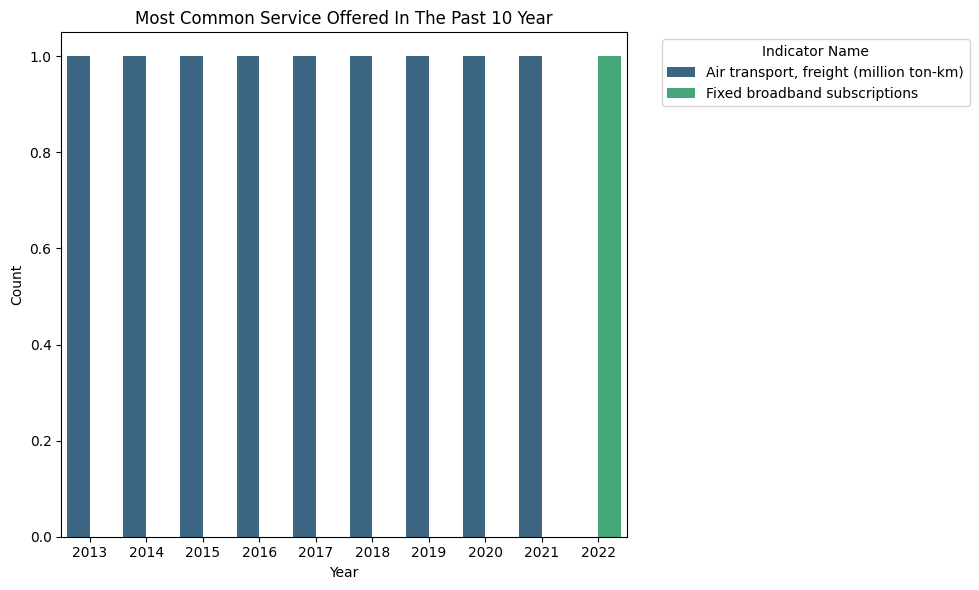

In [590]:
plt.figure(figsize=(10, 6))
sns.countplot(data=most_common_activities.tail(10), x='Year', hue='Indicator Name', palette='viridis', dodge=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Most Common Service Offered In The Past 10 Year')
plt.legend(title='Indicator Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Dropping Unnecessary Columns

In [591]:
services=ocha_dataset.drop(['Country Name', 'Country ISO3', 'Year','Indicator Code', 'Value'], axis=1)
services

,Indicator Name
0,#indicator+name
1,"ICT service exports (BoP, current US$)"
2,"ICT service exports (BoP, current US$)"
3,"ICT service exports (BoP, current US$)"
4,"ICT service exports (BoP, current US$)"
...,...
1335,Personal computers (per 100 people)
1336,Personal computers (per 100 people)
1337,Personal computers (per 100 people)
1338,Personal computers (per 100 people)


In [592]:
services.drop_duplicates(inplace=True)

In [593]:
services.columns

Index(['Indicator Name'], dtype='object')

Natural Language Processing

Text Pre-Processing:Cleaning text

In [594]:
import nltk
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora


In [595]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [596]:
def pre_process(text):
    # Tokenization: Split the text into sentences and the sentences into words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]

    # Lowercase the words and remove punctuation
    words = [[word.lower() for word in sentence if word.isalnum()] for sentence in words]

    # Remove words with fewer than 3 characters
    words = [[word for word in sentence if len(word) > 2] for sentence in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [[word for word in sentence if word not in stop_words] for sentence in words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in words]

    # Stemming
    stemmer = PorterStemmer()
    words = [[stemmer.stem(word) for word in sentence] for sentence in words]
    
    #removing numbers
    words=re.sub(r'\d+','',text)
    
    #removing extra whitespace
    words=re.sub(r'\s+',' ',text).strip()
    
    # Remove punctuation (optional)
    words = re.sub(r'[^\w\s]', '', text)
    

    return words





In [597]:
services['Indicator Name']=services['Indicator Name'].apply(pre_process)
services['Indicator Name']

0                                           indicatorname
1                      ICT service exports BoP current US
31            ICT service exports  of service exports BoP
61      Annual freshwater withdrawals agriculture  of ...
92      Annual freshwater withdrawals domestic  of tot...
123     Annual freshwater withdrawals industry  of tot...
154     Annual freshwater withdrawals total billion cu...
185     Annual freshwater withdrawals total  of intern...
216     Renewable internal freshwater resources total ...
276     Renewable internal freshwater resources per ca...
336     Investment in energy with private participatio...
350     Investment in ICT with private participation c...
353     Investment in transport with private participa...
360     Public private partnerships investment in ener...
374     Public private partnerships investment in ICT ...
375     Public private partnerships investment in tran...
382     Industrial design applications nonresident by ...
405      Indus

Data Exploration

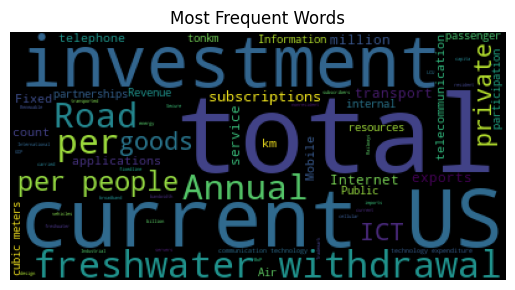

In [598]:
#word cloud
from wordcloud import WordCloud
#Remove rows with missing values in 'Indicator Name' column and convert to strings
cleaned_text = services['Indicator Name'].dropna().astype(str)
# Concatenate all texts into a single string
text_combined = ' '.join(cleaned_text)
# Generate a word cloud image
wordcloud = WordCloud().generate(text_combined)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

In [599]:

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

documents=services['Indicator Name']

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the documents into a bag-of-words matrix
bow_matrix = vectorizer.fit_transform(documents)

# Initialize LDA model on the bag-of-words matrix
num_topics = 10  # Specify the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit LDA model on the bag-of-words matrix
lda_output = lda_model.fit_transform(bow_matrix)


# Fit and transform the documents to obtain vocabulary
count_matrix = count_vectorizer.fit_transform(documents)

# Get the feature names (vocabulary)
vocabulary = count_vectorizer.get_feature_names_out()


# Define specific stop words and numbers
custom_stop_words = {'is', 'for'}  # Example custom stop words
numbers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}  # Numbers to be removed

# Preprocess the vocabulary: remove numbers, specific stop words, and convert to lowercase
preprocessed_vocabulary = [word.lower() for word in vocabulary if word.lower() not in custom_stop_words and not any(num in word for num in numbers)]









In [600]:
print("Original Vocabulary:", vocabulary)

Original Vocabulary: ['100' '1000' '20' '2004' 'agriculture' 'air' 'all' 'and' 'annual'
 'applications' 'area' 'bandwidth' 'billion' 'bits' 'bop' 'broadband' 'by'
 'capita' 'carried' 'carrier' 'cars' 'cellular' 'communication'
 'computers' 'connectivity' 'container' 'count' 'cubic' 'current'
 'density' 'departures' 'design' 'domestic' 'energy' 'equivalent'
 'expenditure' 'exports' 'fixed' 'fixedline' 'foot' 'freight' 'freshwater'
 'from' 'gdp' 'goods' 'households' 'ict' 'imports' 'in' 'index'
 'indicatorname' 'individuals' 'industrial' 'industry' 'information'
 'internal' 'international' 'internet' 'investment' 'km' 'land' 'lcu'
 'liner' 'lines' 'maximum' 'mbps' 'meters' 'million' 'mobile' 'motor'
 'network' 'nonresident' 'of' 'participation' 'partnerships' 'passenger'
 'passengerkm' 'passengers' 'paved' 'people' 'per' 'person' 'personal'
 'population' 'port' 'private' 'public' 'rail' 'railways' 'registered'
 'renewable' 'resident' 'resources' 'revenue' 'road' 'roads' 'routekm'
 'secon

In [601]:
print("Preprocessed Vocabulary:", preprocessed_vocabulary)

Preprocessed Vocabulary: ['agriculture', 'air', 'all', 'and', 'annual', 'applications', 'area', 'bandwidth', 'billion', 'bits', 'bop', 'broadband', 'by', 'capita', 'carried', 'carrier', 'cars', 'cellular', 'communication', 'computers', 'connectivity', 'container', 'count', 'cubic', 'current', 'density', 'departures', 'design', 'domestic', 'energy', 'equivalent', 'expenditure', 'exports', 'fixed', 'fixedline', 'foot', 'freight', 'freshwater', 'from', 'gdp', 'goods', 'households', 'ict', 'imports', 'in', 'index', 'indicatorname', 'individuals', 'industrial', 'industry', 'information', 'internal', 'international', 'internet', 'investment', 'km', 'land', 'lcu', 'liner', 'lines', 'maximum', 'mbps', 'meters', 'million', 'mobile', 'motor', 'network', 'nonresident', 'of', 'participation', 'partnerships', 'passenger', 'passengerkm', 'passengers', 'paved', 'people', 'per', 'person', 'personal', 'population', 'port', 'private', 'public', 'rail', 'railways', 'registered', 'renewable', 'resident', 

In [602]:
# Display the bag-of-words matrix
print("Bag-of-Words Matrix:")
print(bow_matrix.toarray())

Bag-of-Words Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [603]:
# Display the topics and associated top words
num_top_words = 10 # Number of top words to display for each topic

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-num_top_words-1:-1]  # Get indices of top words per topic
    top_words = [vocabulary[i] for i in top_words_idx]
    print(', '.join(top_words))

Topic 1:
freshwater, total, annual, of, withdrawals, withdrawal, resources, internal, maximum, index
Topic 2:
per, km, of, people, road, mobile, telephone, 100, subscribers, fixedline
Topic 3:
subscriptions, per, 100, people, fixed, broadband, cellular, telephone, mobile, renewable
Topic 4:
transport, air, million, internet, secure, servers, billion, cubic, meters, worldwide
Topic 5:
applications, count, by, roads, industrial, design, nonresident, teu, units, foot
Topic 6:
revenue, from, all, services, telecommunication, lcu, telecommunications, of, annual, current
Topic 7:
exports, goods, ict, and, communication, technology, expenditure, information, service, of
Topic 8:
total, per, internet, goods, imports, bandwidth, international, railways, carried, passengers
Topic 9:
transport, with, households, television, participation, us, private, partnerships, public, current
Topic 10:
in, investment, current, us, private, public, partnerships, participation, with, ict


In [604]:
from sklearn.feature_extraction.text import TfidfVectorizer
documents=services['Indicator Name']

# Initialize TfidfVectorizer with preprocessed vocabulary
tfidf_vectorizer = TfidfVectorizer(vocabulary=preprocessed_vocabulary)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Get the feature names (vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()


# Create a DataFrame to display TF-IDF results
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=range(1, len(documents) + 1))

print("TF-IDF Matrix:")
print(tfidf_df)

TF-IDF Matrix:
    agriculture       air       all       and    annual  applications  \
1      0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
4      0.434333  0.000000  0.000000  0.000000  0.297526      0.000000   
5      0.000000  0.000000  0.000000  0.000000  0.297526      0.000000   
6      0.000000  0.000000  0.000000  0.000000  0.297526      0.000000   
7      0.000000  0.000000  0.000000  0.000000  0.338431      0.000000   
8      0.000000  0.000000  0.000000  0.000000  0.360885      0.000000   
9      0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
10     0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
11     0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
12     0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
13     0.000000  0.000000  0.000000 

PPRA Awarded contracts - Kenya - This dataset shows the tenders awarded to various organizations and the services they offered in 2019. We will use this data to train our model in identifying the services a user feels should be improved .

In [605]:
ppra=pd.read_csv('ke_contracts.csv')
ppra

,id,tender-title,tender-ref_No,contract_amount,contract_code,contract_status,created_at,expected_completion_date,month,org_name,pin_number,supplier_name,tender_award_date,type,updated_at,year
0,0,provision of security services.,NTZDC/TN/03/2018/19/20,"4,852,800.00",MZ4BVH7F,Ongoing,2019-03-11 16:02:26,2019-12-31,Dec,Nyayo Tea Zones Develop Corporation,P051165790I,kleen homes security services limited,2019-12-24,State Corporation,8 Months,2019
1,1,supply and delivery of office safe and bookshe...,KFS/038/2018-2019,"42,000.00",VV12D2BJ,Ongoing,2019-01-30 11:24:19,2019-02-15,Dec,Kenya Forest Service,P051540293F,ample express general supplies,2019-12-24,State Corporation,0 Days,2019
2,2,supply of safety shoes,RFX7702,"40,728.00",R1I9USRQ,Ongoing,2019-01-14 15:25:17,2019-01-04,Dec,Kenya Airport Authority,P051143344Z,zocom limited,2019-12-05,State Corporation,0 Days,2019
3,3,supply and delivery of promotional items,GDC/HQS/RFQ/015/2018-2019,"97,257.00",NMFBVWNJ,Ongoing,2019-02-05 11:39:49,2019-01-28,Dec,Geothermal Development Company,P051546295V,tremit enterprises,2019-12-05,State Corporation,0 Days,2019
4,4,supply and delivery of airtime,EACC/25/2018-2019,"940,000.00",HBI8BFUZ,Ongoing,2019-01-28 15:44:25,2019-01-08,Nov,Ethics and Anti-Corruption Commission,P051129820X,safaricom plc,2019-11-30,Commissions and Independent Offices,0 Days,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,4150,supply and delivery of stationery,RFQ NO.1843,"340,000.00",AQLPQDRW,Ongoing,2019-03-08 14:56:43,1970-01-01,Jan,Taita Taveta University,P051680839J,king tai trading company limited,1970-01-01,Public Universities,0 Days,1970
4151,4151,supply and delivery of food stuff,"RFQ NO. 1,809","48,000.00",FSJUVDX8,Ongoing,2019-03-08 15:01:20,1970-01-01,Jan,Taita Taveta University,A009126955Z,lightworm suppliers,1970-01-01,Public Universities,0 Days,1970
4152,4152,provision of airticketing services,JSC/002/2017-2018,"7,970,741.00",IQIG3PUW,Ongoing,2019-03-11 12:55:27,2019-06-06,Jan,Judicial Service Commission,P051121337G,silver bird travel plus limited,1970-01-01,Commissions and Independent Offices,2 Months,1970
4153,4153,provision of maintenance services for governme...,ICTA/NCB/02/2017-2018,"17,942,941.00",AWHLEMKE,Ongoing,2018-08-31 12:19:40,1762-01-19,Jan,ICT Authority,P051321323H,streamlan solutions (e.a) limited,1862-01-18,State Corporation,0 Days,1862


In [606]:
ppra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4155 entries, 0 to 4154
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4155 non-null   int64 
 1   tender-title              4155 non-null   object
 2   tender-ref_No             4155 non-null   object
 3   contract_amount           4155 non-null   object
 4   contract_code             4155 non-null   object
 5   contract_status           4155 non-null   object
 6   created_at                4155 non-null   object
 7   expected_completion_date  4155 non-null   object
 8   month                     4155 non-null   object
 9   org_name                  4155 non-null   object
 10  pin_number                4155 non-null   object
 11  supplier_name             4154 non-null   object
 12  tender_award_date         4155 non-null   object
 13  type                      4155 non-null   object
 14  updated_at              

In [607]:
ppra.columns

Index(['id', 'tender-title', 'tender-ref_No', 'contract_amount',
       'contract_code', 'contract_status', 'created_at',
       'expected_completion_date', 'month', 'org_name', 'pin_number',
       'supplier_name', 'tender_award_date', 'type', 'updated_at', 'year'],
      dtype='object')

In [608]:
ppra_services=ppra.drop(['id','tender-ref_No', 'contract_amount',
       'contract_code', 'contract_status', 'created_at',
       'expected_completion_date', 'month', 'org_name', 'pin_number',
       'supplier_name', 'tender_award_date', 'type', 'updated_at', 'year'], axis=1)


In [609]:
ppra_services.head(10)

,tender-title
0,provision of security services.
1,supply and delivery of office safe and bookshe...
2,supply of safety shoes
3,supply and delivery of promotional items
4,supply and delivery of airtime
5,supply and delivery of epson receipt printer l...
6,supply and delivery of 51 seater bus(re-tender)
7,supply and delivery of foodstuffs (perishables)
8,supply and delivery of huma drugs
9,supply and delivery of huma drugs


In [610]:
ppra_services.drop_duplicates(inplace=True)

NLP:Text Preprocessing

In [611]:
import nltk
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora


In [612]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [613]:
preprocessed_docs=ppra_services['tender-title'].apply(pre_process)
preprocessed_docs

0                          provision of security services
1       supply and delivery of office safe and bookshe...
2                                  supply of safety shoes
3                supply and delivery of promotional items
4                          supply and delivery of airtime
                              ...                        
4148    tender for provision of medical group life  gr...
4149        provision of cleaning and fumigation services
4151                    supply and delivery of food stuff
4152                   provision of airticketing services
4153    provision of maintenance services for governme...
Name: tender-title, Length: 2651, dtype: object

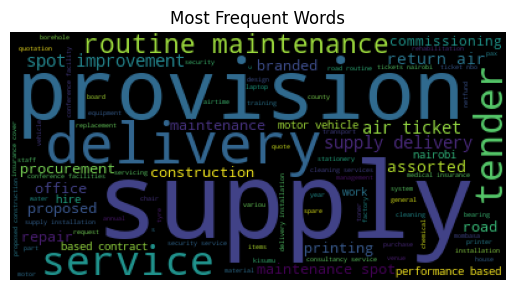

In [616]:
#word cloud
from wordcloud import WordCloud
#Remove rows with missing values in 'Indicator Name' column and convert to strings
cleaned_text = ppra_services['tender-title'].dropna().astype(str)
# Concatenate all texts into a single string
text_combined = ' '.join(cleaned_text)
# Generate a word cloud image
wordcloud = WordCloud().generate(text_combined)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

In [617]:
ppra_services

,tender-title
0,provision of security services.
1,supply and delivery of office safe and bookshe...
2,supply of safety shoes
3,supply and delivery of promotional items
4,supply and delivery of airtime
...,...
4148,"tender for provision of medical, group life & ..."
4149,provision of cleaning and fumigation services
4151,supply and delivery of food stuff
4152,provision of airticketing services


Merge data from OCHA Services Data and PPRA Awarded Contracts.
Ensure data consistency and integrity before model training.

In [621]:
# Standardize column names for merging
services.rename(columns={'Indicator Name': 'service'}, inplace=True)
ppra_services.rename(columns={'tender-title': 'service'}, inplace=True)

In [622]:
# Merge datasets based on the 'service' column
merged_data = pd.merge(services, ppra_services, on='service', how='inner')

# View information about the merged dataset
print(merged_data.info())

# Save the merged dataset if needed
merged_data.to_csv('merged_data.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   service  0 non-null      object
dtypes: object(1)
memory usage: 124.0+ bytes
None


In [623]:
merged_data.head()

,service
